<class 'numpy.ndarray'>
(200, 267, 3)
<class 'PIL.JpegImagePlugin.JpegImageFile'>
(267, 200)


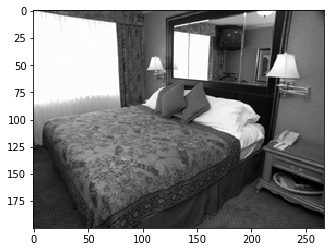

In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
categories = ['bedroom', 'Coast', 'Forest', 'Highway', 'industrial',
           'Insidecity', 'kitchen', 'livingroom', 'Mountain', 'Office',
           'OpenCountry', 'store', 'Street', 'Suburb', 'TallBuilding'] 

train_img_set=[]
test_img_set=[]

img = cv.imread("training\\"+categories[1]+"\\"+str(1)+".jpg",cv.IMREAD_GRAYSCALE)
img2 = cv.imread('training\\bedroom\\0.jpg')
plt.imshow(img2, cmap=plt.cm.gray)
img_PIL = Image.open('training\\bedroom\\0.jpg')
print(type(img2))
print(img2.shape)
print(type(img_PIL))
print(img_PIL.size)
#print(img.shape)

In [68]:
class image_label():

    def __init__(self, img=None,number=None,label=None):
        self.img = img
        self.number=number
        self.label=label

In [75]:
def sift_descriptors(img):
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return des

#def dictionary(descriptors, N):   # em
#    em = cv.EM(N)
#    em.train(descriptors)
#    return np.float32(em.getMat("means")), np.float32(em.getMatVector("covs")), np.float32(em.getMat("weights"))[0]

def all_descriptors():   # used for train
    train_img_set = []
    descriptors = []
    for i in range(15):
        for j in range(100):
            img_ = cv.imread("training\\"+categories[i]+"\\"+str(j)+".jpg",cv.IMREAD_GRAYSCALE)
            img = image_label(img_,j,i)
            train_img_set.append(img)
            descriptors.append(sift_descriptors(img_))     
    return descriptors

def generate_gmm(descriptors, N ):
    words =  descriptors
    #Training GMM of size N
    means, covs, weights = dictionary(words, N)
    #Throw away gaussians with weights that are too small:
    th = 1.0 / N
    means = np.float32([m for k,m in zip(range(0, len(weights)), means) if weights[k] > th])
    covs = np.float32([m for k,m in zip(range(0, len(weights)), covs) if weights[k] > th])
    weights = np.float32([m for k,m in zip(range(0, len(weights)), weights) if weights[k] > th])

    np.save("means.gmm", means)
    np.save("covs.gmm", covs)
    np.save("weights.gmm", weights)
    return means, covs, weights

In [76]:
em = cv.EM(N)

AttributeError: module 'cv2.cv2' has no attribute 'EM'

In [79]:
print(descriptors)
print(descriptors[0])
des = all_descriptors()
print(len(des))

[array([[  6.,  31.,  18., ...,   1.,  23.,   2.],
       [ 74.,   2.,   0., ...,   0.,   0.,   9.],
       [  2.,   7.,  12., ...,   0.,  33., 123.],
       ...,
       [ 11.,   1.,   0., ...,   0.,   0.,   0.],
       [ 23.,  10.,   0., ...,  50.,   4.,  19.],
       [ 23.,  22.,   6., ...,   0.,   0.,   0.]], dtype=float32), array([[  6.,  31.,  18., ...,   1.,  23.,   2.],
       [ 74.,   2.,   0., ...,   0.,   0.,   9.],
       [  2.,   7.,  12., ...,   0.,  33., 123.],
       ...,
       [ 11.,   1.,   0., ...,   0.,   0.,   0.],
       [ 23.,  10.,   0., ...,  50.,   4.,  19.],
       [ 23.,  22.,   6., ...,   0.,   0.,   0.]], dtype=float32)]
[[  6.  31.  18. ...   1.  23.   2.]
 [ 74.   2.   0. ...   0.   0.   9.]
 [  2.   7.  12. ...   0.  33. 123.]
 ...
 [ 11.   1.   0. ...   0.   0.   0.]
 [ 23.  10.   0. ...  50.   4.  19.]
 [ 23.  22.   6. ...   0.   0.   0.]]
1500


In [81]:
print(type(descriptors[0]))

<class 'numpy.ndarray'>


In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, random_state=0).fit(train_features[0])


image_a=np.tile(train_features[0][:,None,:],(1,2,1))
a=image_a.copy()
var = np.diagonal(gm.covariances_, axis1=1, axis2=2)
np.subtract(image_a,gm.means_,out=image_a)
np.divide(image_a,var,out=image_a)

likelihood=gm.predict_proba(train_features[0])
mean_dev = np.multiply(likelihood[:,:,None], image_a).mean(axis=0) 
print(mean_dev.shape)
mean_dev = np.multiply(1 / np.sqrt(gm.weights_[None,:,None]), mean_dev) 

cov_dev = np.multiply(likelihood[:,:,None], image_a**2 - 1).mean(axis=0)
cov_dev = np.multiply(1 / np.sqrt(2 * gm.weights_[None,:,None]), cov_dev)
print(mean_dev.shape)
print(cov_dev.shape)
fisher_vectors = np.concatenate([mean_dev, cov_dev], axis=1)

In [ ]:
def all_descriptors(image_set):
    features = np.empty((0,128))
    sift = cv.SIFT_create()
    for i in image_set:
        kp, des = sift.detectAndCompute(np.array(i.img), None)      
        features = np.concatenate((features,des),axis=0)
    return features



In [86]:
import numpy as np
a = np.empty((0,128))
print(a.shape)
a = np.concatenate((a,des[0]),axis=0)
print(a.shape)
a = np.concatenate((a,des[1]),axis=0)
print(a.shape)
print(des[1].shape)
print(type(a))

(0, 128)
(257, 128)
(544, 128)
(287, 128)
<class 'numpy.ndarray'>


In [91]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, random_state=0).fit(a)
print(gm.means_.shape)
print(gm.weights_.shape)
print(gm.covariances_.shape)

(2, 128)
(2,)
(2, 128, 128)
